# Приоритизация гипотез и анализ результатов A/B тестирования.

**Описание проекта**

**Контекст**

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты. 

**Описание данных**

*Данные для первой части:*

Файл `/datasets/hypothesis.csv`
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

</br></br>
*Данные для второй части:*

Файл `/datasets/orders.csv`
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.
</br></br>

Файл `/datasets/visitors.csv`
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

**План работы:**

I. Выгрузка и предобработка данных.

II. Приоритизация гипотез.
1. Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
2. Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
3. Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объяснить, почему так произошло.

III. Анализ A/B-теста.
1. Построить график кумулятивной выручки по группам. Сделать выводы и предположения.
2. Построить график кумулятивного среднего чека по группам. Сделать выводы и предположения.
3. Построить график относительного изменения кумулятивного среднего чека группы B к группе A. Сделать выводы и предположения.
4. Построить график кумулятивного среднего количества заказов на посетителя по группам. Сделать выводы и предположения.
5. Построить график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделать выводы и предположения.
6. Построить точечный график количества заказов по пользователям. Сделать выводы и предположения.
7. Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.
8. Построить точечный график стоимостей заказов. Сделать выводы и предположения.
9. Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.
10. Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделать выводы и предположения.
11. Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделать выводы и предположения.
12. Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделать выводы и предположения.
13. Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделать выводы и предположения.
14. Принять решение по результатам теста и объяснить его. 

IV. Вывод

## Выгрузка и предобработка данных

Ознакомимся с полученными данными и проведем предобработку при необходиомсти.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import scipy.stats as stats

In [2]:
import os

pth1_1 = '/datasets/hypothesis.csv'
pth1_2 = 'datasets/hypothesis.csv'
pth2_1 = '/datasets/orders.csv'
pth2_2 = 'datasets/orders.csv'
pth3_1 = '/datasets/visitors.csv'
pth3_2 = 'datasets/visitors.csv'

if os.path.exists(pth1_1):
    hypothesis = pd.read_csv(pth1_1)
    orders = pd.read_csv(pth2_1)
    visitors = pd.read_csv(pth3_1)
elif os.path.exists(pth1_2):
    hypothesis = pd.read_csv(pth1_2)
    orders = pd.read_csv(pth2_2)
    visitors = pd.read_csv(pth3_2)
else:
    print("Проверьте правильность пути к датасету")

Выведем основную информацию про полученные таблицы.

In [24]:
pd.set_option('display.max_colwidth', None) # для вывода таблицы с гипотезами полностью

df_names = {'hypothesis': hypothesis, 
            'orders': orders, 
            'visitors': visitors}

for name, df in df_names.items():
    print(f'\n------------Данные таблицы {name}-----------\n')
    df.info()
    display(df.head(10))
    print(f'Полных дубликатов в таблице: {df.duplicated().sum()}')
    print('\n')


------------Данные таблицы hypothesis-----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   hypothesis  9 non-null      object 
 1   reach       9 non-null      int64  
 2   impact      9 non-null      int64  
 3   confidence  9 non-null      int64  
 4   efforts     9 non-null      int64  
 5   ICE         9 non-null      float64
 6   RICE        9 non-null      float64
dtypes: float64(2), int64(4), object(1)
memory usage: 636.0+ bytes


,hypothesis,reach,impact,confidence,efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2


Полных дубликатов в таблице: 0



------------Данные таблицы orders-----------

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1016 non-null   int64         
 1   visitor_id      1016 non-null   int64         
 2   date            1016 non-null   datetime64[ns]
 3   revenue         1016 non-null   int64         
 4   group           1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B
10,3649131742,879864040,2019-08-15,4008,A


Полных дубликатов в таблице: 0



------------Данные таблицы visitors-----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


Полных дубликатов в таблице: 0




Итак, пропущенных значений и дубликатов в таблицах нет, и числовые значения имеют соотвествующие типы данных. Однако, названия столбцов следует привести к змеиному регистру, а поля с датами - к типу datetime. 

In [26]:
for name, df in df_names.items():
    
    
    df.columns = [x.replace('Id', '_id').lower() for x in df.columns]
    

    try:
        df['date'] = df['date'].map(
            lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
        )
        
        print(f'\n------------Данные таблицы {name}-----------\n')
        df.info()
        display(df.head(10))
        print('\n')
        
    except:
        print(f'\n------------Данные таблицы {name}-----------\n')
        df.info()
        display(df.head(10))
        print('\n')





------------Данные таблицы hypothesis-----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   hypothesis  9 non-null      object 
 1   reach       9 non-null      int64  
 2   impact      9 non-null      int64  
 3   confidence  9 non-null      int64  
 4   efforts     9 non-null      int64  
 5   ice         9 non-null      float64
 6   rice        9 non-null      float64
dtypes: float64(2), int64(4), object(1)
memory usage: 636.0+ bytes


,hypothesis,reach,impact,confidence,efforts,ice,rice
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2





------------Данные таблицы orders-----------

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1016 non-null   int64         
 1   visitor_id      1016 non-null   int64         
 2   date            1016 non-null   datetime64[ns]
 3   revenue         1016 non-null   int64         
 4   group           1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B
10,3649131742,879864040,2019-08-15,4008,A





------------Данные таблицы visitors-----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


Преобработка данных завершена.

## Приоритизация гипотез

### Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [30]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


По фреймворку ICE наиболее перспективными являются гипотезы "Запустить акцию, дающую скидку на товар в день рождения", "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей", "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".

### Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [29]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


По фреймворку RICE гипотезы "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" и "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" также находятся в топе самых перспективных гипотез, однако гипотеза "Запустить акцию, дающую скидку на товар в день рождения" находится теперь лишь на 5 месте. На такое положение гипотезы повлиял параметр Reach. Эта гипотеза имеет высокие показатели влияния на пользователей и при этом мы в ней очень уверены, но доля пользователей, на которую повлияет эксперимент, слишком мала. 

По фреймворку ICE самые приоритетные гипотезы: 
1. Запустить акцию, дающую скидку на товар в день рождения
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

По фреймворку RICE:
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

Приоритизация гипотез изменилась из-за влиянияния параметра Reach - охват. Гипотеза "Запустить акцию, дающую скидку на товар в день рождения" оказалась на первом месте по фреймворку ICE, однако по RICE её не оказалось даже в тройке лидеров. Дело в довольно малой доле пользователей, на которых повлияет гипотеза.

## Анализ A/B-теста

Перед началом анализа результатов A/B-теста проверим, все ли пользователи чётко разделены по группам и нет ли среди них тех, кто попал в обе группы сразу.

In [8]:
users_in_both_groups = orders.query('group == "A"').merge(orders.query('group == "B"'), on='visitor_id', how='inner')['visitor_id']
all_users = orders['visitor_id'].nunique()

print(f'Всего пользователей, попавших в обе группы: {users_in_both_groups.nunique()}')
print(f'Доля таких пользователей: {(users_in_both_groups.nunique() / all_users * 100):.2f}%')

Всего пользователей, попавших в обе группы: 58
Доля таких пользователей: 5.63%


В собранных данных A/B-теста таких пользователей оказалось 58, их доля от всех пользователей составляет 5.63%. Наличие подобных пользователей говорит о нарушении правил проведения A/B тестирования. Один и тот же пользователь должен находиться только в одной из двух групп - A или B. Иначе он начинает влиять на обе группы сразу, искажая результаты A/B-теста.

Следует обратить внимание на метод разделеления пользователей по группам. 

Для дальнейшего анализа данные таких пользователей будут удалены.

In [9]:
orders = orders.query('visitor_id not in @users_in_both_groups')

### Построим график кумулятивной выручки по группам

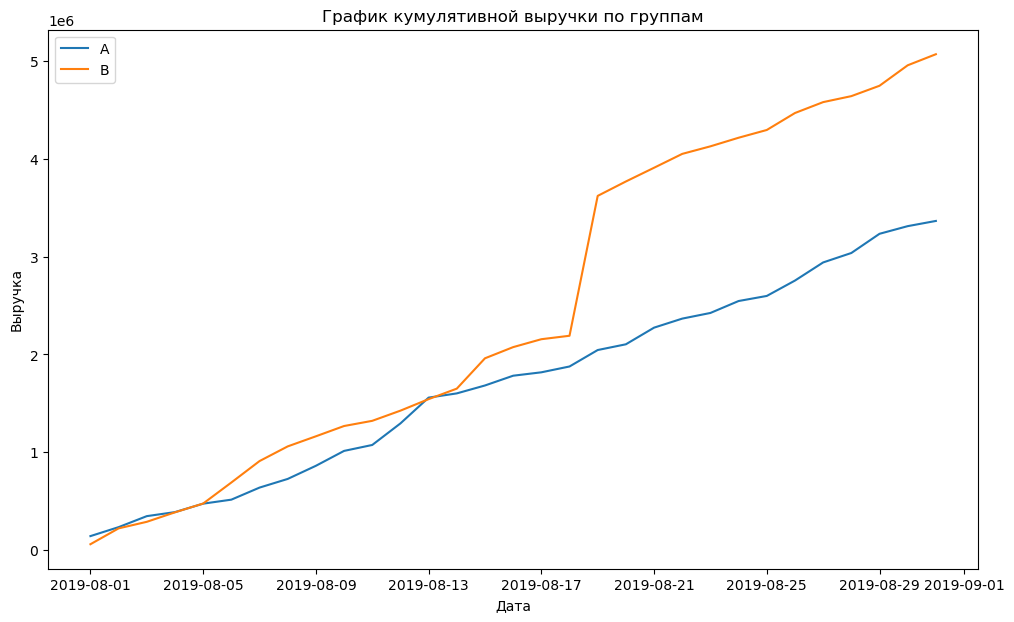

In [10]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

ordersAggregated = (
    datesGroups
    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
           .agg({'date' : 'max', 
                 'group' : 'max', 
                 'transaction_id' : 'nunique', 
                 'visitor_id' : 'nunique', 
                 'revenue' : 'sum'}), axis=1)
    .sort_values(by=['date','group'])
                   )

visitorsAggregated = (datesGroups
                      .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                             .agg({'date' : 'max', 
                                   'group' : 'max', 
                                   'visitors' : 'sum'}), axis=1)
                      .sort_values(by=['date','group'])
                     )

# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = (datesGroups
                    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
                           .agg({'date' : 'max', 
                                 'group' : 'max', 
                                 'transaction_id' : 'nunique', 
                                 'visitor_id' : 'nunique', 
                                 'revenue' : 'sum'}), axis=1)
                    .sort_values(by=['date','group'])
                   )

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = (datesGroups
                      .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                             .agg({'date' : 'max', 
                                   'group' : 'max', 
                                   'visitors' : 'sum'}), axis=1)
                      .sort_values(by=['date','group'])
                     )
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12,7))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.show()

До 17.08 несильно, но стабильно лидировала группа B, а между 17.08 и 21.08 разница между группами значительно выросла и держалась так до конца проведения теста. Судя по всему, имеют место быть аномально большие заказы в группе В. Их следует обработать и убрать.

### Построим график кумулятивного среднего чека по группам

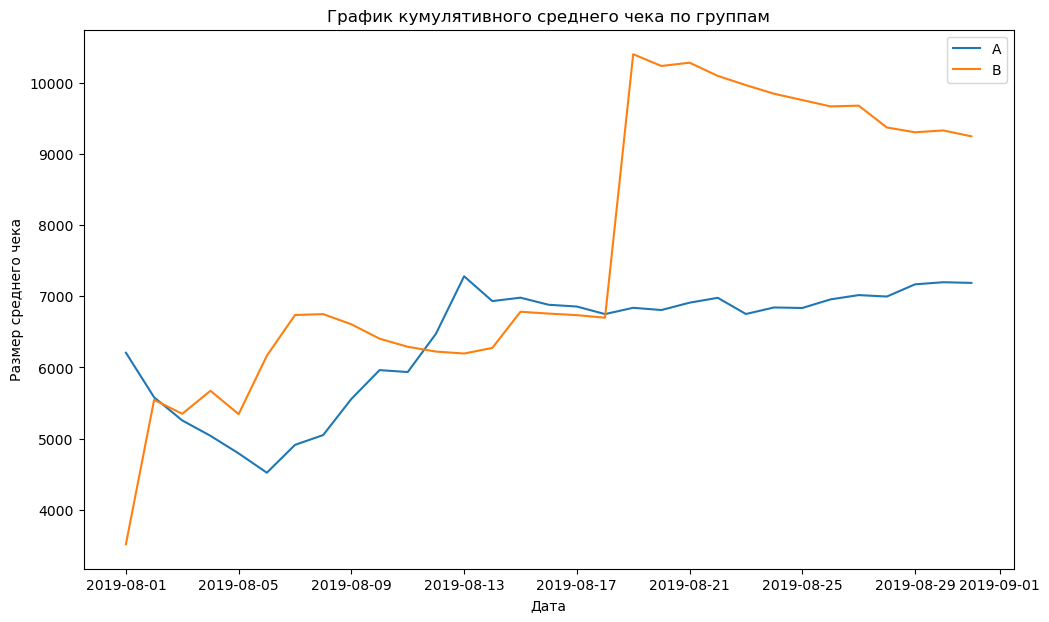

In [11]:
plt.figure(figsize=(12,7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Размер среднего чека')
plt.show()

До середины теста значения среднего чека по группам колебались. После середины теста значение среднего чека по группе А закрепилось около 7000, а средний чек группы В резко вырос в тот же период 17.08 - 21.08, после чего стал убывать - очевидно влияние выбросов. 

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A

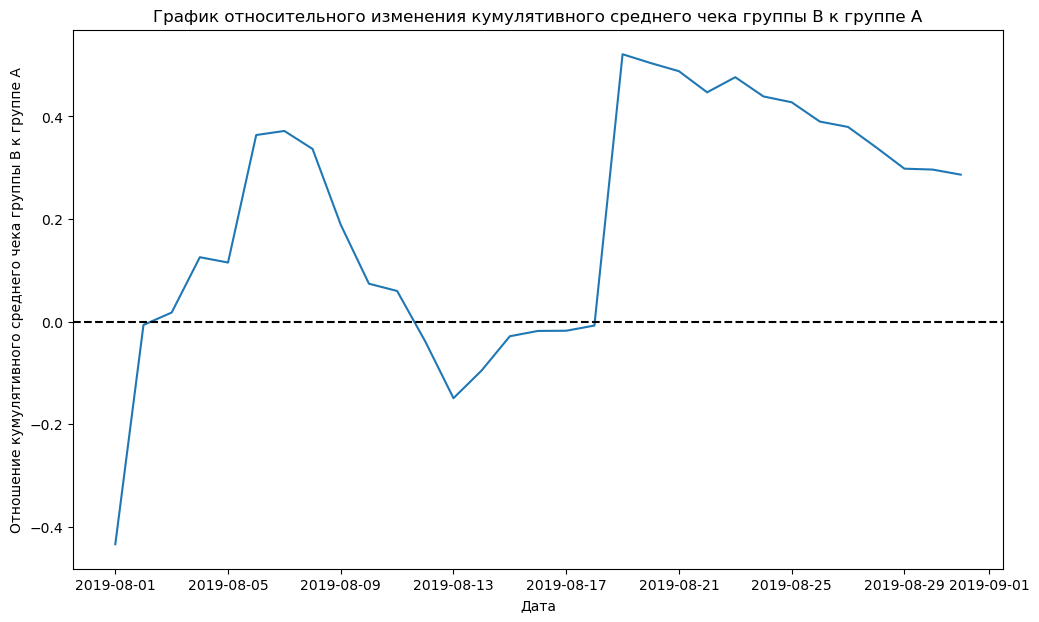

In [36]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12,7))

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Отношение кумулятивного среднего чека группы B к группе A')
plt.show()

До середины теста отношение кумулятивного среднего чека группы В к группе А колебалось. 17.08 - 21.08 наблюдается резкий скачок отношения, группа В значительно превысила группу А, но значение отношения после скачка начало тут же убывать.

### Построим график кумулятивного среднего количества заказов на посетителя по группам

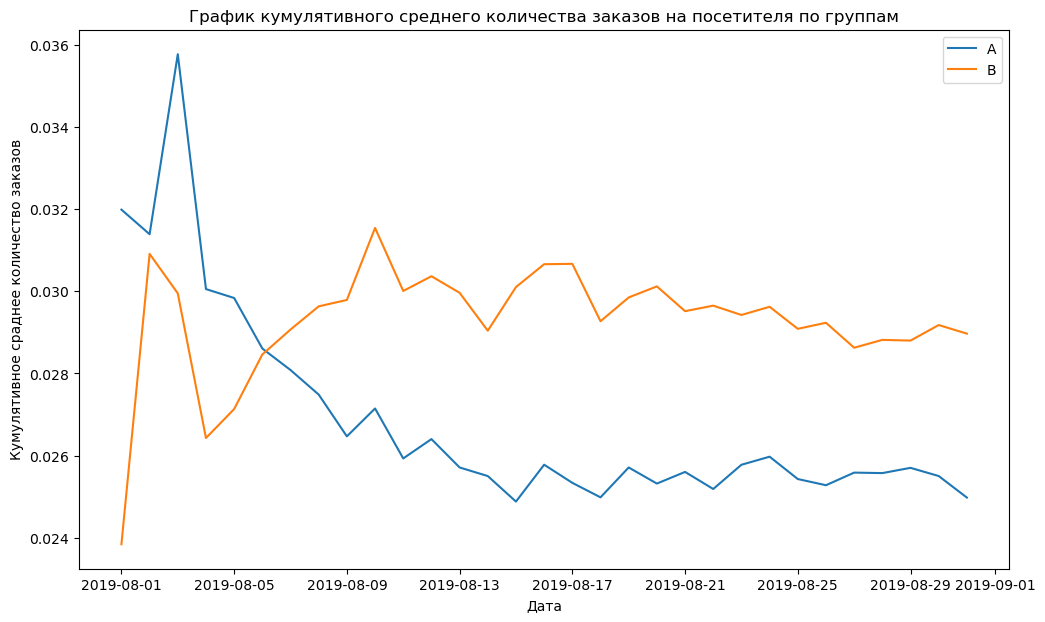

In [37]:
# считаем среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(12,7))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивное сраднее количество заказов')
plt.show()

В начале теста значения кумулятивного среднего количества заказов по группам колебались, но после 17.08 они зафиксировались, причем значение группы В выше группы А.

### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

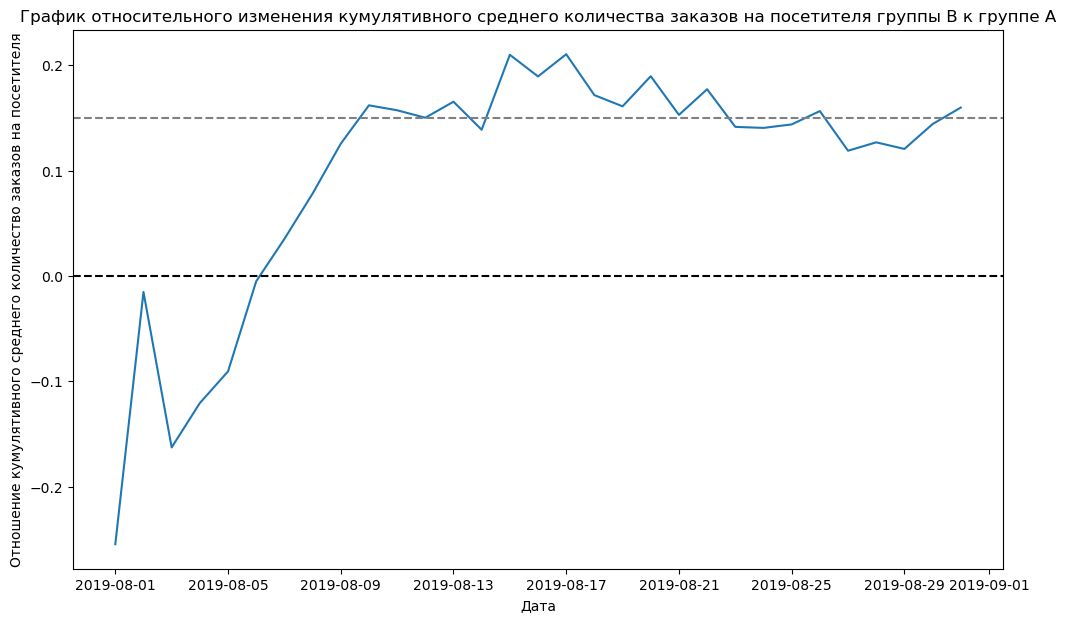

In [39]:
mergedCumulativeConversions = (cumulativeDataA[['date','conversion']]
                               .merge(cumulativeDataB[['date','conversion']], 
                                      left_on='date', 
                                      right_on='date', 
                                      how='left', 
                                      suffixes=['A', 'B'])
                              )
plt.figure(figsize=(12,7))
plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
         label="Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A")


plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')

plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Отношение кумулятивного среднего количество заказов на посетителя')
plt.show()

В целом отношение отношение среднего количества заказов на посетителя всё ещё колеблется, но стабильно между 0.1 и 0.2. Значит, группа В показывает более лучший результат по сравнению с группой А.

### Построим точечный график количества заказов по пользователям

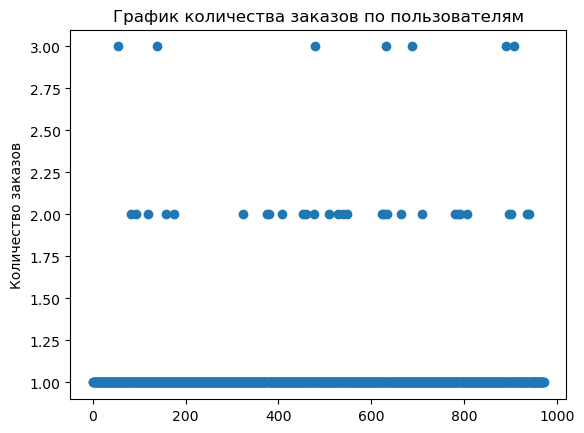

In [15]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

ordersByUsers.columns = ['visitor_id', 'orders']
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.title('График количества заказов по пользователям')
plt.ylabel('Количество заказов')
plt.show()

Пользователи совершали не более трех покупок на человека. Следует определить, считать ли 2-3 покупки на человека аномалией или нет.

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя

In [16]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


Не более 5% пользователей совершили более одной покупки, и не более 1% - более двух. Разумно будет считать 1 покупку верхней границей числа заказов для пользователей. Покупатели с 2-3 покупками будем считать аномальными и впоследствии отсеем.

### Построим точечный график стоимостей заказов

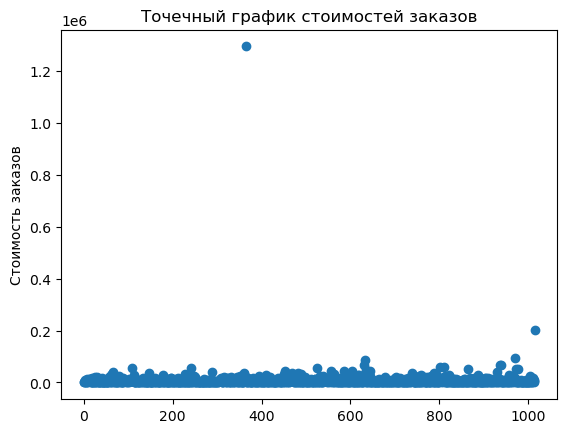

In [17]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

plt.title('Точечный график стоимостей заказов')
plt.ylabel('Стоимость заказов')
plt.show()

Наблюдается два больших выброса около значений 1.200.000 и 200.000. Определим величину стоимости заказа, выше которой остальные будем считать аномально большими и отсеем.

### Посчитаем 95-й и 99-й перцентили стоимости заказов

In [18]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


Не более 5% пользователей совершили покупку на сумму более чем 26785, и не более 1% - на сумму более 53904. Будем считать аномально большими заказы на сумму более 26785 и отсеем их.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Сформулируем гипотезы. 
- Нулевая: различий в среднем количестве заказов между группами нет. 
- Альтернативная: различия в среднем между группами есть.

Для их проверки вопспользуемся непараметрическим тестом Манна-Уитни.

In [19]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)


ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("p-value: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("Относительный прирост среднего числа заказов группы B: {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.011
Относительный прирост среднего числа заказов группы B: 0.160


Значение p-value 0.011 меньше 0.05. Значит, нулевую гипотезу о равенстве средних количеств заказов между группами отвергаем. Различие в средних между группами стало статистически значимо, причем относительный выигрыш группы В составлил 16%.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем гипотезы.
- Нулевая гипотеза: различий в среднем чеке между группами нет. 
- Альтернативная гипотеза: различия в среднем чеке между группами есть. 

Для их проверки вопспользуемся непараметрическим тестом Манна-Уитни.

In [20]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительный прирост среднего чека заказа группы B: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.829
Относительный прирост среднего чека заказа группы B: 0.287


Значение p-value составляет 0.829, что ~~значительно~~ выше 0.05. Значит, гипотезу об отсутствии различий в среднем чеке между группами не отвергаем. Однако выигрыш группы В составил почти 29%.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Для начала выведем число аномальных пользователей.

In [21]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 4]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 4]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 26785]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.shape[0])

51


Таких пользователей оказалось 51. 

Теперь посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Подготовим выборки количества заказов по пользователям по группам теста и применим к ним статистический критерий Манна-Уитни.

In [22]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


print('p-value: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост среднего числа заказов группы B: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value: 0.017
Относительный прирост среднего числа заказов группы B: 0.156


Результаты по среднему количеству заказов практически не изменились. Нулевую гипотезу о равенстве средних количеств заказов между группами всё также отвергаем. Относительный выигрыш группы В практически не изменился - 15.6% 

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [23]:
print(
    'p-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительный прирост среднего чека заказа группы B: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value: 0.741
Относительный прирост среднего чека заказа группы B: -0.053


Значение p-value составляет 0.741, что всё ещё ~~значительно~~ выше 0.05. Значит, гипотезу об отсутствии различий в среднем чеке между группами, как и ранее, не отвергаем. Изменения в среднем чеке между группами остаются не значимыми.

Однако влияние аномально дорогих заказов исчезло, из-за чего относительный прирост среднего чека заказа группы B упал с выигрыша в 29% до проигрыша в 5%. 

### Примем решение по результатам теста

Опишем полученные в ходе проведения теста результаты: 
- Обнаружено статистически значимое различие по среднему количеству заказов между группами как по "сырым", так и по "очищенным" данным
- Между группами нет статически значимого различия по среднему чеку
- График относительного изменения кумулятивного среднего количества заказов показывает, что группа В имеет лучшие результаты по сранению с группой А: результаты имеют тенденцию к росту, либо зафиксировались около среднего значения
- График различия среднего чека колеблется, сделать определённые выводы не получается

На основе этих фактов можем принять решение: тест следует остановить и признать успешным. Группа В стала значительно чаще совершать заказы, при этом средняя стоимость заказа не изменилась.

## Вывод

В ходе выполнения проекта были выполнены приоритизация гипотез и анализ результатов A/B тестирования.

Для приоритизации гипотез были использованы фреймворки ICE и RICE. По фреймворку ICE самые приоритетные гипотезы:
1. Запустить акцию, дающую скидку на товар в день рождения
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

По фреймворку RICE:
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

Приоритизация гипотез изменилась из-за влиянияния параметра Reach - охват. Гипотеза "Запустить акцию, дающую скидку на товар в день рождения" оказалась на первом месте по фреймворку ICE, однако по RICE её не оказалось даже в тройке лидеров. Дело в довольно малой доле пользователей, на которых повлияет гипотеза.

В собранных данных A/B-теста пользователей, оказавшихся в обеих группах тестирования, оказалось 58, их доля от всех пользователей составляет 5.63%. Наличие подобных пользователей говорит о нарушении правил проведения A/B тестирования. Один и тот же пользователь должен находиться только в одной из двух групп - A или B. Иначе он начинает влиять на обе группы сразу, искажая результаты A/B-теста.

Следует обратить внимание на метод разделеления пользователей по группам и пересмотреть его. А для дальнейшего анализа данные таких пользователей были удалены.

При простроении графика кумулятивной выручки по группам выявлено, что до 17.08 несильно, но стабильно лидировала группа B, а между 17.08 и 21.08 разница между группами значительно выросла и держалась так до конца проведения теста. Здесь имели место быть аномально большие заказы в группе В. 

При построении графика относительного изменения кумулятивного среднего чека группы B к группе A обнаружено, что до середины теста отношение кумулятивного среднего чека группы В к группе А колебалось. 17.08 - 21.08 наблюдается резкий скачок отношения, группа В значительно превысила группу А, но значение отношения после скачка начало тут же убывать.

График кумулятивного среднего количества заказов на посетителя по группам показал, что в начале теста значения колебались, но после 17.08 они зафиксировались, причем значение группы В выше группы А.

График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A показал, что в целом отношение отношение среднего количества заказов на посетителя всё ещё колеблется, но стабильно между 0.1 и 0.2. Значит, группа В показывает более лучший результат по сравнению с группой А.

Также построение точечных графиков и подсчетов 95 и 99 перцентилей показало следующее:
- Пользователи совершали не более трех покупок на человека
- Не более 5% пользователей совершили более одной покупки, и не более 1% - более двух
- Среди стоимостей заказов наблюдается два больших выброса около значений 1.200.000 и 200.000
- Не более 5% пользователей совершили покупку на сумму более чем 26785, и не более 1% - на сумму более 53904

Аномальными были признаны данные пользователей, совершивших более одной покупки или совершивших покупку на сумму более 26785.

При проведении статистических тестов выявлено следующее:
- Обнаружено статистически значимое различие по среднему количеству заказов между группами как по "сырым", так и по "очищенным" данным
- Между группами нет статически значимого различия по среднему чеку ни по "сырым", ни по "очищенным"

На основе изложенных выше фактов можем принять решение: тест следует остановить и признать успешным. Группа В стала значительно чаще совершать заказы, при этом средняя стоимость заказа не изменилась.